# Monitor ingested files
This notebook can be used to track the ingested files progress in the system.
### Steps
* **Input:** It reads the JSON files list as an input from data source storage
* For each file, track the expected output at the different stages of the system (All monitoring stages are mentioned below in the next heading).
* If expected output found at a specific stage, then that stage monitoring for the specific file marked as True otherwise False.
* **Output:** At the end, it will output the summarized view of ingested files in the system. For example: 
    * How many files processed successfully at all stages?
    * How many files fails?
    * Which file fails at what stage? (for investigation etc..)

### Monitoring Stages
Following are the four stages in the system where this notebook tracks the files progress and look for expected output.
* Parsed JSON on Azure storage
* Video Indexer Uploading/Processing
* Cosmos Insights Stored
* Azure Search Indexed

**Note:**: 
* this notebooks requires the azure storage, cosmos DB, azure search SDK's. See `requirements.txt`.
* this notebooks requires careful consideration of the names' relation in these instances, before running adjustments regarding naming conventions might be necessary 

In [1]:
"""
Copyright (c) Microsoft Corporation.
Licensed under the MIT license.
"""
import os
from azure.storage.blob import BlobServiceClient
from azure.cosmos import CosmosClient, ContainerProxy
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from enrichment.metadata_parser.metadata_parser import MetadataParser
from enrichment.metadata_parser.json_reader import json_reader
from pathlib import Path
import json
import logging
import requests
import sys
import pandas as pd
from dotenv import load_dotenv
load_dotenv(".env")

True

#### This section is about client initializations for each level monitoring i.e. Azure Storage, Cosmos DB, Video Indexer and Azure Search

In [2]:
STORAGE_ACCOUNT_NAME = os.getenv("WALDO_STORAGE_ACCOUNT_NAME") 
ACCOUNT_STORAGE_KEY = os.getenv("WALDO_UPLOAD_STORAGE_KEY")
CONTAINER_NAME_SRC = os.getenv("WALDO_CONTAINER_SRC") 

# connect to source storage container to read JSON files to start monitoring 
STORAGE_SRC_CS = f"DefaultEndpointsProtocol=https;AccountName={STORAGE_ACCOUNT_NAME};AccountKey={ACCOUNT_STORAGE_KEY};EndpointSuffix=core.windows.net"
SERVICE_SRC = BlobServiceClient.from_connection_string(conn_str=STORAGE_SRC_CS) 
container_client_src = SERVICE_SRC.get_container_client('videos')

# connect to the storage container where parsed_json files should exist
CONTAINER_NAME_DST = os.getenv("WALDO_CONTAINER_DST") 
STORAGE_DST_CS = f'DefaultEndpointsProtocol=https;AccountName={STORAGE_ACCOUNT_NAME};AccountKey={ACCOUNT_STORAGE_KEY};EndpointSuffix=core.windows.net'
SERVICE_DST = BlobServiceClient.from_connection_string(conn_str=STORAGE_DST_CS )
container_client_dst = SERVICE_DST.get_container_client('silver')

# initialize the Cosmos client
COSMOS_ENDPOINT = os.getenv("STG_COSMOS_ENDPOINT") 
COSMOSDB_KEY = os.getenv("STG_COSMOS_KEY")
DATABASE_NAME = os.getenv("STG_COSMOS_NAME") 
CONTAINER_NAME = os.getenv("STG_CONTAINER") 
cosmos_client = CosmosClient(COSMOS_ENDPOINT, COSMOSDB_KEY )
database = cosmos_client.get_database_client(DATABASE_NAME)
cosmos_container = database.get_container_client(CONTAINER_NAME)

# initialize the Video Indexer client
VI_LOCATION_ID = os.getenv("VI_LOCATION_ID")
VI_ACCOUNT_ID = os.getenv("VI_ACCOUNT_ID") 
VI_ACCESS_TOKEN = os.getenv("VI_ACCESS_TOKEN")

# initialize the Azure search client
AZ_SEARCH_INDEX = os.getenv("AZ_SEARCH_INDEX") 
AZ_SEARCH_ENDPOINT = os.getenv("AZ_SEARCH_ENDPOINT")
AZ_SEARCH_KEY = os.getenv("AZ_SEARCH_KEY")
az_search_client = SearchClient(AZ_SEARCH_ENDPOINT, AZ_SEARCH_INDEX, AzureKeyCredential(AZ_SEARCH_KEY))

### Definitions 

In [3]:
class VideoIndexerDownloadAPI():

    def __init__(self, location, vi_account_id, access_token):
        self.vi_account_id = vi_account_id
        self.access_token = access_token
        self.vi_location = location

    def _get_uploaded_video_batch(self, page_size=50, skip=0):

        headers = {
            'Authorization': 'Bearer ' + self.access_token
        }

        params = {

            'pageSize': page_size,
            'skip': skip
        }

        list_videos_req = requests.get(
            'https://api.videoindexer.ai/{location}/Accounts/{acc_id}/Videos'.format(
                location=self.vi_location,
                acc_id=self.vi_account_id
            ),
            params=params,
            headers=headers
        ).json()

        logging.info('Videos: {}'.format(list_videos_req))
        return list_videos_req

    def list_uploaded_videos(self):
        """
        Get all the video names which were uploaded to the AVAM
        """

        page_size = 50
        skip = 0
        video_list = list()

        is_done = False

        while not is_done:
            page_results = self._get_uploaded_video_batch(page_size, skip)
            skip += page_size
            video_list.extend(page_results['results'])
            is_done = page_results['nextPage']['done']
        return video_list  

vi_object = VideoIndexerDownloadAPI(VI_LOCATION_ID, VI_ACCOUNT_ID, VI_ACCESS_TOKEN)

def is_parsed_json_exists(blob_list: list, blob_name: str)-> bool:
    """Find the parsed JSON file in a list of blobs."""
    json_files = [x['name'] for x in blob_list if x['name'].startswith(blob_name) and x['name'].endswith('.json')]
    if len(json_files):
        return True
    return False

def is_vi_insights_cosmos_stored(cosmos_client: ContainerProxy, videoId: str)-> bool:
    """Find the Insights stored on the Cosmos with the VideoId as key parameter."""

    items = list(cosmos_client.read_all_items())
    matching_items = [i for i in items if i['videoId'] == videoId]
    if len(items):
        return True
    return False

def is_insights_indexed(azuresearch_client: SearchClient, videoId: str)-> bool:
    """Find the index on azure search storage with the VideoId and VideoName as keys."""
    result = {}
    try:
        result = azuresearch_client.get_document(key=videoId)
    except:
        print("Document Key Not Found...")
    if result:
        return True
    return False

def is_vi_processed_successful(videos_dict: dict, video_name: str)-> bool:
    """Find the video name in the hash table of successfully processed VI videos."""
    videos = [i for i in videos_dict.keys() if video_name in i]
    
    if len(videos):
        return True
    return False

def is_parsed_json_exists(blob_list: list, blob_name: str, json_version: str)-> bool:
    """Find the parsed JSON file in a list of blobs."""
    json_files = [x['name'] for x in blob_list if x['name'].startswith(blob_name) and x['name'].endswith(json_version+".json")]
    if len(json_files):
        return True
    return False

def is_processed_video_exists(videos_list: dict, video_hash: str)-> bool:
    """Find the parsed JSON file in a list of blobs."""
    video_hash = video_hash.split('.')[0]
    video_files = [i for i in videos_list.keys() if video_hash in i]
    if len(video_files):
        return True
    return False

### Pre-Workflow data preparation

In [4]:
#get list of all files to monitor
files_to_monitor = list(container_client_src.list_blobs())
files_to_monitor = [i for i in files_to_monitor if i['name'].endswith(".json")]
print("Total files to monitor: {}".format(len(files_to_monitor)))

#get list of all blobs for parsed JSON lookup
list_dst_files = list(container_client_dst.list_blobs())
#filter out the JSON files
list_dst_files = [i for i in list_dst_files if i['name'].endswith(".json")]
print("Total blobs in Parsed JSON Lookup: {}".format(len(list_dst_files)))

#store the lookup table for successfully processed videos as videoName and videoId
vi_processed_videos = {video['name']: video['id'] for video in vi_object.list_uploaded_videos() if video['state'] == 'Processed'}
print("Total processed videos: {}".format(len(list_dst_files)))

Total files to monitor: 30
Total blobs in Parsed JSON Lookup: 19794
Total processed videos: 19794


## Main Workflow

In [5]:
#to disable warnings in the output cell
import logging, sys
logging.disable(sys.maxsize)

In [6]:
#For each file, find the status of expected output at the four levels/stages and stored them as a list of dictionaries
processed_files = []
for index, item in enumerate(files_to_monitor):

    #dictionary object to store the track status of each file
    temp = dict()
    temp['name'] = item['name']
    temp['json_parsed'] = False
    temp['vi_processing'] = False
    temp['cosmos_stored'] = False
    temp['search_indexed'] = False

    #Download JSON file to get the relevant fields for monitoring
      
    # initialize parser and parse
    data = json_reader(container_client_src, item['name'])
    parser = MetadataParser()
    parsed = parser.parse_metadata(data)
    matching_video_name = parsed.get('matching_video_name', "")
    video_hash_id = parsed.get('video_hash_id', "")
    json_version = parsed.get('version', "")
    print("\nProcessing {} : count: {} matching_video_name: {} video_hash_id: {} json_version: {}".format(item['name'], index, matching_video_name, video_hash_id, json_version ))

    if matching_video_name and video_hash_id and json_version: 

        #check if the parsed JSON file exist on supposed storage
        blob_name_to_search = matching_video_name.split('.')[0] 
            
        if is_parsed_json_exists(list_dst_files, blob_name_to_search, str(json_version)):
            temp['json_parsed'] = True

            video_Id = vi_processed_videos.get(video_hash_id, "")
            #check if video processed on Video Indexer is successful
            if  video_Id:
                
                temp['vi_processing'] = True
                 #check if insights found on Cosmos with the videoId as a key
                 
                if is_vi_insights_cosmos_stored(cosmos_container, video_Id):
                    temp['cosmos_stored'] = True

                    #check if insights indexed on search storage, videoId as key
                    if is_insights_indexed(az_search_client, video_Id):
                        temp['search_indexed'] = True

    processed_files.append(temp)


Processing footage8_microsoft_Donovan_Mitchell_Driving_Finger_Roll_Layup_Made_ENT202200020439660001r/footage8_microsoft_Donovan_Mitchell_Driving_Finger_Roll_Layup_Made_ENT202200020439660001r.json : count: 0 matching_video_name: footage8_microsoft_Donovan_Mitchell_Driving_Finger_Roll_Layup_Made_ENT202200020439660001r.mov video_hash_id: f76c3030fefd3a07fb26390aa2c9f1dd7611700c1ec4b1dae060b1b440ee647d.mov json_version: 1

Processing footage8_microsoft_Donovan_Mitchell_Driving_Finger_Roll_Layup_Made_ENT202200020439660002r/footage8_microsoft_Donovan_Mitchell_Driving_Finger_Roll_Layup_Made_ENT202200020439660002r.json : count: 1 matching_video_name: footage8_microsoft_Donovan_Mitchell_Driving_Finger_Roll_Layup_Made_ENT202200020439660002r.mov video_hash_id: db7634700fd01e675c5ef78ff2cfd131e9512c39b3ae45d9b10661ed35558b16.mov json_version: 1

Processing footage8_microsoft_Donovan_Mitchell_Driving_Finger_Roll_Layup_Made_ENT202200020439660003r/footage8_microsoft_Donovan_Mitchell_Driving_Finger_R

## Summary

In [7]:
### Conversion to Dataframe for analysis
df = pd.DataFrame(processed_files)
df = df.drop_duplicates(subset='name', keep="first")
df

,name,json_parsed,vi_processing,cosmos_stored,search_indexed
0,footage8_microsoft_Donovan_Mitchell_Driving_Fi...,True,False,False,False
1,footage8_microsoft_Donovan_Mitchell_Driving_Fi...,True,False,False,False
2,footage8_microsoft_Donovan_Mitchell_Driving_Fi...,True,False,False,False
3,footage8_microsoft_Donovan_Mitchell_Driving_Fi...,True,False,False,False
4,footage8_microsoft_Donovan_Mitchell_Driving_Fi...,True,False,False,False
5,footage8_microsoft_Donovan_Mitchell_Driving_Fi...,True,False,False,False
6,footage8_microsoft_Donovan_Mitchell_Driving_Fl...,True,False,False,False
7,footage8_microsoft_Donovan_Mitchell_Driving_Fl...,True,False,False,False
8,footage8_microsoft_Donovan_Mitchell_Driving_Fl...,True,False,False,False
9,footage8_microsoft_Donovan_Mitchell_Driving_Fl...,True,False,False,False


In [8]:
print("JSON Parsed Stats\n {} \n".format(df.json_parsed.value_counts()))
print("VI Processing Stats\n {}".format(df.vi_processing.value_counts()))
print("Cosmos Data Entry Stats\n {}".format(df.cosmos_stored.value_counts()))
print("Search indexed Stats\n {}".format(df.search_indexed.value_counts()))

JSON Parsed Stats
 True    30
Name: json_parsed, dtype: int64 

VI Processing Stats
 False    30
Name: vi_processing, dtype: int64
Cosmos Data Entry Stats
 False    30
Name: cosmos_stored, dtype: int64
Search indexed Stats
 False    30
Name: search_indexed, dtype: int64


In [9]:
group_df = df.groupby(['json_parsed','vi_processing', 'cosmos_stored', 'search_indexed']).count()
display(group_df)

,,,,name
json_parsed,vi_processing,cosmos_stored,search_indexed,
True,False,False,False,30


Text(0, 0.5, 'Percentage')

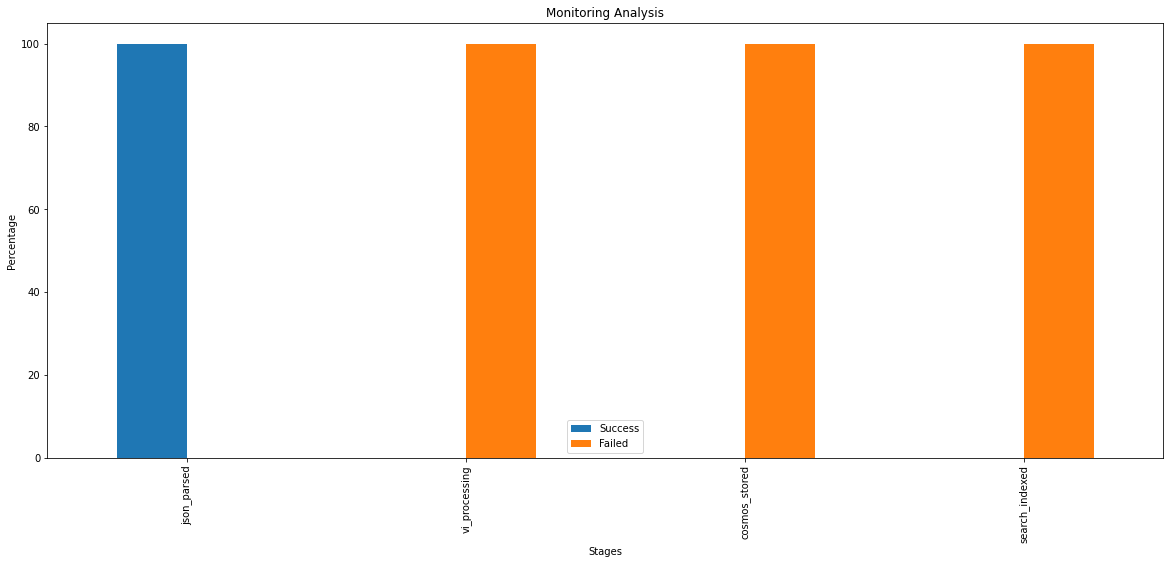

In [10]:
from matplotlib import pyplot as plt

success = []
failures = []
indexes = []
for index, col in enumerate(df.columns):
    if not index:
        continue
    #print(col)
    success.append(int(df[col].sum())/len(df) * 100)
    failures.append(100 - (int(df[col].sum())/len(df) * 100))
    indexes.append(col)
# stats_true.append(int(df.json_parsed.value_counts())/len(df) * 100)
# Create the pandas DataFrame
analysis_df = pd.DataFrame({"Success": success, "Failed": failures}, index = indexes)
#plt.figure(figsize=(100, 100))
analysis_df.plot(figsize=(20,8), kind='bar')
plt.title("Monitoring Analysis")
plt.xlabel("Stages")
plt.ylabel("Percentage")
